# Tensor Flowを用いたロジスティック回帰，MLP実装

# 0.  Tensorflowとは？

Googleが提供する機械学習用のフレームワーク．
機械学習用のフレームワークは他にもたくさん存在するが，Tensorflowは現在世界で最も使用されているフレームワークであると言われている．

pythonによって書くが、内部はC++やcudaによって書かれている．

### 'define and run'という形式をとり、まず計算グラフを定義し、それに対してデータを流すという使い方となっている．

※tensor flowインストールの際は，conda内でpipを使うとcondaのデータ破損原因になるので，$ conda install tensorflow　または，anaconda-navigator->Environmentsより，uninstall項目からtensorflowをinstallするのがよいと思われます．

### 必要なライブラリのインポート

In [226]:
import tensorflow as tf
from __future__ import print_function
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split

# 1.　計算グラフの構築と実行

計算グラフを構築するためにTensorflow側が用意している型を用いる必要がある.<br>

Tensorflowが用意している種類と使い方は以下のとおり．
1. tf.constant ... ハイパーパラメータなど，実行前から形(shape)の決まった定数に用いる．
2. tf.placeholder ... データの入力など，実行するまでデータのshapeはわからないが変わらないデータを入れるときに用いる(初期化不要)．例えば，データセットの大きさは実行するまでわからない．
3. tf.Variable ... ネットワークの重みなど，学習中に値が変わる最適化対象を入れる(初期化必要)． 

## 1.0　計算グラフの実行方法
計算グラフを構築するだけでは，実際に計算は行われない．<br>
計算を実行して値を評価するためには， TensorflowのSessionを作成する必要がある．<br>
例えば，$x$という値の出力が欲しい時は，その値をSessionのrunメソッドに渡してあげる．<br>
具体的には以下のように書けば良い．
```python
with tf.Session() as sess:
    result = sess.run(x)
```

## 1.1　まずはtf.constant(定数)を用いる

In [227]:
x = tf.constant(1)
y = tf.constant(2)

add_op = tf.add(x, y)
print(x,y)
print(add_op)

Tensor("Const_2:0", shape=(), dtype=int32) Tensor("Const_3:0", shape=(), dtype=int32)
Tensor("Add:0", shape=(), dtype=int32)


ここで表示された結果は定義された計算グラフについての情報で、実際に計算は行われていないことに注意．
- 以下のように計算グラフを実行させて値を確認する．

In [228]:
with tf.Session() as sess:
    print(sess.run(add_op))

3


In [229]:
with tf.Session() as sess:
    x_, y_, add_op_ = sess.run([x, y, add_op])

In [230]:
print('x is ',x_)
print('y is ', y_)
print('x + y = ',add_op_)

x is  1
y is  2
x + y =  3


足し算掛け算は以下のようにも書ける．

In [231]:
x = tf.constant(1)
y = tf.constant(2)

## 足し算掛け算は+,*で書いて良い
add_op = x+y

with tf.Session() as sess:
    x_, y_, add_op_ = sess.run([x, y, add_op])

In [232]:
print('x is ',x_)
print('y is ', y_)
print('x + y = ',add_op_)

x is  1
y is  2
x + y =  3


## 1.2　tf.placeholderを用いる(データを流す用)

placeholderは初期化不要の変数だが、intかfloatか指定する必要がある．
- tf.float32
- tf.int32

評価対象の変数の計算のために必要なデータの入力はsess.run内のfeed_dict引数内で行うことができる．<br>
feed_dictで渡す変数は一つとは限らないので，辞書型で渡す．

In [233]:
data = tf.placeholder(tf.int32)
x = tf.constant(5)
op = data*x

with tf.Session() as sess:
    result1 = sess.run(op, feed_dict={data: 5})
    result2 = sess.run(op, feed_dict={data: 10})

In [234]:
print('5*5=',result1)
print('5*10=',result2)

5*5= 25
5*10= 50


## 1.3　tf.Variableを用いる(変数用)

- 実行前に全てのVariableは初期化する必要がある．
    - sess.run(tf.global_variables_initializer())で一度に初期化できる
- Variableへの代入はtf.assignを用いる

In [235]:
var1 = tf.Variable(0)
const1 = tf.constant(2)

add_op = var1+const1
# Variableへの代入はassignを用いる
var1 = tf.assign(var1, add_op)
print (var1)

Tensor("Assign:0", shape=(), dtype=int32_ref)


In [236]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
# var1が毎回更新されている
    print(sess.run([var1]))
    print(sess.run([var1]))
    print(sess.run([var1]))

[2]
[4]
[6]


# 2，ロジスティック回帰

### 今回はKNNで扱った手書き文字分類を実装する．前回ロジスティック回帰で扱った問題は二値分類であったが，今回は多クラス分類問題となる．その際，誤差関数は交差エントロピー誤差を用いる．

### データの準備

In [237]:
# データのロード（比較的時間がかかる）
mnist = fetch_mldata('MNIST original', data_home='./data/')

# data : 画像データ， target : 正解ラベル
X, T = mnist.data, mnist.target

# 画像データは0~255の数値となっているので，0~1の値に変換
X = X / 255.

#　訓練データとテストデータに分ける
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

# データのサイズ
N_train = X_train.shape[0]
N_test = X_test.shape[0]

# ラベルデータをint型に統一し，学習に使いやすいようにone-hot-vectorに変換
T_train = np.eye(10)[T_train.astype("int")]
T_test = np.eye(10)[T_test.astype("int")]

In [238]:
print ('訓練データのサイズは', N_train)
print ('テストデータのサイズは', N_test)
print ('画像データのshapeは', X_train.shape)
print ('ラベルデータのshapeは', T_train.shape)
print ('ラベルデータの数値の例：')
print (T_train[:10])

訓練データのサイズは 56000
テストデータのサイズは 14000
画像データのshapeは (56000, 784)
ラベルデータのshapeは (56000, 10)
ラベルデータの数値の例：
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


## one-hot-vectorとは？
たとえば$a$が，0~4の整数のみを含むベクトルだとわかっている時に，各行の数字に該当する列の要素のみを1にし，その他を0にする．
$$
\begin{equation*}
a=
\begin{pmatrix}
3\\
1\\
4\\
2\\
0
\end{pmatrix}\to
a\_onehot = 
\begin{pmatrix}
0, 0, 0, 1, 0\\
0, 1, 0, 0, 0\\
0, 0, 0, 0, 1\\
0, 0, 1, 0, 0\\
1, 0, 0, 0, 0
\end{pmatrix}
\end{equation*}
$$
学習における正解ラベルデータは，one-hot-vectorで表されることが多い．

## ロジスティック回帰クラスの定義

In [239]:
class LogisticRegression:
    def __init__(self, n_in, n_out):
        # n_in : 入力次元数
        # n_out : 出力次元数
        self.W = tf.Variable(tf.zeros([n_in, n_out])) # 重み
        self.b = tf.Variable(tf.zeros(n_out)) # バイアス

    def __call__(self, x):
        ### TODO ###
        y = tf.sigmoid(tf.matmul(x,self.W)+self.b) # Forward Propagation
        ### TODO ###
        return y

## グラフの構築

In [240]:
#グラフの初期化
tf.reset_default_graph()

In [241]:
#必要なパラメータの定義
# Learning rate (学習率)
lr = 0.7
# epoch数 （学習回数）
n_epoch = 25
# ミニバッチ学習における1バッチのデータ数
batchsize = 100

In [242]:
# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x = tf.placeholder(tf.float32, [None, 784]) # 28*28次元 
t = tf.placeholder(tf.float32, [None, 10]) # 10クラス

In [243]:
# モデルの定義
# 入力次元数：784，　出力次元数：10
model = LogisticRegression(784, 10)

In [244]:
# y : predictionの結果
y = model(x)

In [245]:
# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y)
cost = tf.reduce_mean(xentropy)

In [246]:
# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

In [247]:
# 精度評価
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## グラフの実行

In [248]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(N_train)

        for i in range(0, N_train, batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = X_train[perm[i:i+batchsize]]
            t_batch = T_train[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / N_train
        print('Train loss %.3f | ' %(loss), end="")

        # Test model
        print ("Accuracy: %.3f"%(accuracy.eval(feed_dict={x: X_test, t: T_test})))

epoch 0 | Train loss 1.684 | Accuracy: 0.873
epoch 1 | Train loss 1.612 | Accuracy: 0.882
epoch 2 | Train loss 1.597 | Accuracy: 0.886
epoch 3 | Train loss 1.589 | Accuracy: 0.890
epoch 4 | Train loss 1.584 | Accuracy: 0.892
epoch 5 | Train loss 1.580 | Accuracy: 0.893
epoch 6 | Train loss 1.577 | Accuracy: 0.894
epoch 7 | Train loss 1.575 | Accuracy: 0.895
epoch 8 | Train loss 1.573 | Accuracy: 0.895
epoch 9 | Train loss 1.571 | Accuracy: 0.896
epoch 10 | Train loss 1.570 | Accuracy: 0.898
epoch 11 | Train loss 1.568 | Accuracy: 0.898
epoch 12 | Train loss 1.567 | Accuracy: 0.898
epoch 13 | Train loss 1.566 | Accuracy: 0.900
epoch 14 | Train loss 1.565 | Accuracy: 0.899
epoch 15 | Train loss 1.564 | Accuracy: 0.900
epoch 16 | Train loss 1.563 | Accuracy: 0.900
epoch 17 | Train loss 1.563 | Accuracy: 0.900
epoch 18 | Train loss 1.562 | Accuracy: 0.901
epoch 19 | Train loss 1.561 | Accuracy: 0.901
epoch 20 | Train loss 1.561 | Accuracy: 0.901
epoch 21 | Train loss 1.560 | Accuracy: 0.90

## バッチ学習について
バッチ学習とは，大量のデータを扱う際に，データをいくつかの小さな集合にわけ，その集合ごとに勾配を計算し，パラメータを更新する手法である．今までは全てのデータを参照してから，一度重みの更新を行っていたため，大量の計算を行っても重み更新が少しづつしか行えない問題があった．バッチ学習はこの問題を解決する手法である．今回の問題では，56000個の訓練データを100個ずつのバッチに分けて，そのバッチごとに勾配計算する操作を一回の操作とし，その操作をepoch回数分(25回)分計算を回して重み更新を行う．つまり，$560×25=14000回$の重み更新を行っている．

# 3. MLP

## MLPクラスについて
以下のような要件のネットワークを構築する．
```
    入力 : x　
-> Fully connected layer 1 (input : x, outputの次元数 : 256, 活性化関数 : relu関数)
-> Fully connected layer 2 (input : layer1の出力， outputの次元数 : 256, 活性化関数 : relu関数)
-> Fully connected layer 3 (input : layer2の出力， outputの次元数 : 10)
-> 出力 : out
```

<details>
    <summary>ヒント</summary>
    <div><br>
    - TensorflowでFully connected layerはtf.layers.dense (inputs, units, activation=None)で呼ぶことができる．
    <br>
    - inputs : 入力データ
    <br>
    - units :  outputの次元数
    <br>
    - activation : 活性化関数の種類（デフォルトでは無し）
    <br>
    - relu関数はTensorflowでtf.nn.reluと表される．
    </div>
</details>

## MLPクラスの定義

In [249]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 256, activation=tf.nn.relu)
    layer_2 =  tf.layers.dense(layer_1, 256, activation=tf.nn.relu)
    out = tf.layers.dense(layer_2, 10, activation=tf.nn.softmax)
    ### TODO
    return out

## グラフの構築

In [250]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.1
# epoch数 （学習回数）
n_epoch = 25
# ミニバッチ学習における1バッチのデータ数
batchsize = 100

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x = tf.placeholder(tf.float32, [None, 784]) # 28*28次元 
t = tf.placeholder(tf.float32, [None, 10]) # 10クラス

# MLPクラスのモデルを用いてpredictionを行う
y = MLP(x)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y)
cost = tf.reduce_mean(xentropy)

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## グラフの実行

In [251]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(N_train)

        for i in range(0, N_train, batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = X_train[perm[i:i+batchsize]]
            t_batch = T_train[perm[i:i+batchsize]]
            
            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / N_train
        print('Train loss %.5f | ' %(loss), end="")

        # Test model
        print ("Test Accuracy: %.3f"%(accuracy.eval(feed_dict={x: X_test, t: T_test})))

epoch 0 | Train loss 1.86202 | Test Accuracy: 0.752
epoch 1 | Train loss 1.70881 | Test Accuracy: 0.762
epoch 2 | Train loss 1.69818 | Test Accuracy: 0.766
epoch 3 | Train loss 1.69243 | Test Accuracy: 0.770
epoch 4 | Train loss 1.68877 | Test Accuracy: 0.771
epoch 5 | Train loss 1.68552 | Test Accuracy: 0.774
epoch 6 | Train loss 1.67121 | Test Accuracy: 0.835
epoch 7 | Train loss 1.62061 | Test Accuracy: 0.845
epoch 8 | Train loss 1.61059 | Test Accuracy: 0.852
epoch 9 | Train loss 1.60479 | Test Accuracy: 0.855
epoch 10 | Train loss 1.60069 | Test Accuracy: 0.857
epoch 11 | Train loss 1.59742 | Test Accuracy: 0.860
epoch 12 | Train loss 1.59439 | Test Accuracy: 0.862
epoch 13 | Train loss 1.59218 | Test Accuracy: 0.864
epoch 14 | Train loss 1.59003 | Test Accuracy: 0.865
epoch 15 | Train loss 1.58821 | Test Accuracy: 0.866
epoch 16 | Train loss 1.58655 | Test Accuracy: 0.867
epoch 17 | Train loss 1.58519 | Test Accuracy: 0.869
epoch 18 | Train loss 1.58377 | Test Accuracy: 0.869
epo

# < Tensorflow 応用編 >

Tensorflowには学習コードをさらに抽象化する<strong>Estimator</strong>というものがある．<br>
Estimatorを用いるとEstimator.train()を呼ぶだけでepoch数だけfor文を書くなどの手間が省けるため，コードの可読性が上がり，<br>
実用でも広く使われている．

## Estimatorの使い方
Estimatorの使用方法について大まかなコードの流れの例を説明したものが以下のサンプルコードである．
```python
estimator = tf.estimator.Estimator(model_fn)
estimator.train(train_input_fn)
result = estimator.evaluate(test_input_fn)
```
model_fnにモデルの内容（ネットワーク構造，ロス関数，optimizerの設定）を書き，Estimatorに渡す．<br>
Estimatorは訓練用のデータの情報が入っているtrain_input_fnを引数としてtrainメソッドを呼ぶことで訓練を行う．<br>
さらに，テスト用のデータの情報が入っているtest_input_fnを引数としてevaluateメソッドを呼ぶことでテストを行い，学習データになかったデータに対する汎用性を評価する．

In [252]:
# Estimatorでの実装時に用いられる関数はone-hot-vectorではなくクラスラベルをそのまま入力することが多い
t_train = np.argmax(T_train, axis=1)
t_test = np.argmax(T_test, axis=1)

In [253]:
def my_model(features, labels, mode, params):
    # モデルを定義する
    net = features['x']
    for units in params['hidden_units']:
        # 入力がnetで出力がunits個，活性化関数がrelu関数である全結合層
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)

    # netを入力としてクラス分のunit数に出力することでlogitsを計算する
    logits = tf.layers.dense(net, params['n_classes'], activation=None)
    
    # ロスの定義
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # 推定結果を計算する
    predicted_classes = tf.argmax(logits, 1)
    
    # 正解率の計算方法を指定する
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes)
    metrics = {'accuracy': accuracy}
  
    # evaluationモードのとき
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=metrics)

    # lossを最小化するオプティマイザを定義する
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
     
    # trainモードのとき
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [254]:
def main():
    batch_size = 100

    # 訓練データ用
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X_train},
        y=t_train,
        batch_size=batch_size,
        num_epochs=5,
        shuffle=True)
    
    # テストデータ用
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": X_test},
        y=t_test,
        num_epochs=1,
        shuffle=False)

    # model functionを用いてestimatorを定義する
    estimator = tf.estimator.Estimator(
        model_fn=my_model,
        params={
            'hidden_units': [256, 256], #  256ノード持つ2つの隠れ層
            'n_classes': 10, # モデルは結果を3つのクラスから選ぶ
        })
     
    # モデルを訓練
    estimator.train(input_fn=train_input_fn)
    
    # モデルの評価
    eval_result = estimator.evaluate(input_fn=eval_input_fn)
    
    print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

In [255]:
main()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/zy/k0hjq5rd7gd_m7sg5fcymcr40000gn/T/tmp9tzn2yba/model.ckpt.
INFO:tensorflow:loss = 2.3959197998, step = 1
INFO:tensorflow:global_step/sec: 105.49
INFO:tensorflow:loss = 0.290475964546, step = 101 (0.949 sec)
INFO:tensorflow:global_step/sec: 107.257
INFO:tensorflow:loss = 0.207505777478, step = 201 (0.932 sec)
INFO:tensorflow:global_step/sec: 107.378
INFO:tensorflow:loss = 0.225855708122, step = 301 (0.931 sec)
INFO:tensorflow:global_step/sec: 107.627
INFO:tensorflow:loss = 0.181460916996, step = 401 (0.929 sec)
INFO:tensorflow:global_step/sec: 107.563
INFO:tensorflow:loss = 0.078400619328, step = 501 (0.930 sec)
INFO:tensorflow:global_step/sec: 107.183
INFO:tensorflow:loss = 0.124422132969, step = 601 (0.933 sec)
INFO:tensorflow:global_step/sec: 106.824
INFO:tensorflow:loss = 0.096629448235, step = 701 (0.936 sec)


## Tensor Flowを用いた回帰，二値分類の問題

### 前回MLP問題として扱った回帰，二値分類の問題をTensor Flowを用いて実装する

## $f(x)=x+0.3\sin(2\pi x)$ に沿って生成したノイズを含むデータ点から，近似曲線を推定する

### 必要なライブラリのインポート 

In [303]:
import pylab as plt
import numpy as np

### データの作成

In [304]:
def create_toy_dataset(func, n=100):
    #サイズ(n,1)の配列に0~1の乱数を格納
    x = np.random.uniform(size=(n, 1))
    #関数の返り値にノイズを発生
    t = func(x) + np.random.uniform(-0.1, 0.1, size=(n, 1))
    return x, t

#f(x)=x+0.3sin(2πx)を定義
def func(x):
        return x + 0.3 * np.sin(2 * np.pi * x)

In [305]:
#学習データ
x, t = create_toy_dataset(func)
x_size=x.shape[0]

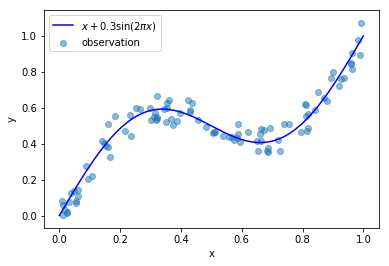

In [306]:
#観測データと正解の関数

plt.scatter(x, t, alpha=0.5, label="observation")
x_test = np.linspace(0, 1, 1000)[:, np.newaxis]
plt.plot(x_test, func(x_test), color="blue", label="$x+0.3\sin(2\pi x)$")
plt.legend(loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### MLPクラスの定義

In [307]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 3, activation=tf.nn.tanh)
    out = tf.layers.dense(layer_1, 1)
    ### TODO
    return out

### グラフの構築

In [333]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.1
# epoch数 （学習回数）
n_epoch = 5000
# ミニバッチ学習における1バッチのデータ数
batchsize = 10

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x_ = tf.placeholder(tf.float32, [None, 1]) # 1次元 
t_ = tf.placeholder(tf.float32, [None, 1]) # 1次元

# MLPクラスのモデルを用いてpredictionを行う
y_ = MLP(x_)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
cost = tf.reduce_mean(tf.square(y_ - t_))

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(t_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

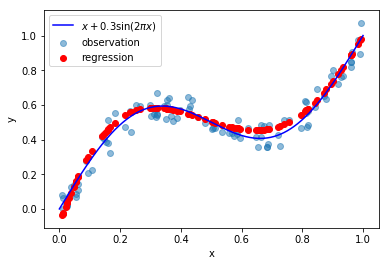

In [336]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(x_size)
    
        for i in range(0, x_size, batchsize):
            
            # ミニバッチ分のデータを取ってくる
            X_batch = x[perm[i:i+batchsize]]
            t_batch = t[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x_:X_batch, t_:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss /x_size
        print('Train loss %.5f  ' %(loss))
        
        # Test model
        #print ("Test Accuracy: %.3f"%(sess.run(accuracy,feed_dict={x_: x, t_: t})))
    pred,x_data=sess.run([y_,x_], feed_dict={x_:x, t_:t})
    plt.scatter(x, t, alpha=0.5, label="observation")    
    x_test = np.linspace(0, 1, 1000)[:, np.newaxis]
    plt.plot(x_test, func(x_test), color="blue", label="$x+0.3\sin(2\pi x)$")
    plt.scatter(x_data, pred, color="red", label="regression")
    plt.legend(loc="upper left")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## 二値分類

In [343]:
def create_toy_dataset2():
    x = np.random.uniform(-1., 1., size=(1000, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)




In [344]:
#データ生成
x, labels = create_toy_dataset2()
print(x.shape)
x_size=x.shape[0]

(1000, 2)


(1000, 2)
(1000, 1)


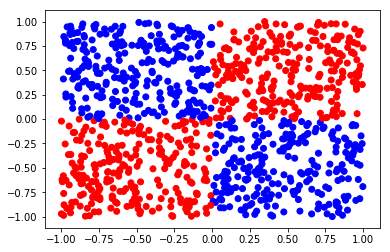

In [345]:
#可視化
print(x.shape)
print(labels.shape)
colors = ["blue", "red"]
plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])
plt.show()


In [346]:
def MLP(x):
    ### TODO
    layer_1 =  tf.layers.dense(x, 4, activation=tf.nn.tanh)
    out =  tf.layers.dense(layer_1, 1,activation=tf.nn.sigmoid)
    ### TODO
    return out

In [357]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 1
# epoch数 （学習回数）
n_epoch = 1000

# ミニバッチ学習における1バッチのデータ数
batchsize = 100

# 入力
# placeholderを用いると，データのサイズがわからないときにとりあえずNoneとおくことができる．
x_ = tf.placeholder(tf.float32, [None, 2]) # 1次元 
t_ = tf.placeholder(tf.float32, [None, 1]) # 1次元

# MLPクラスのモデルを用いてpredictionを行う
y_ = MLP(x_)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=t_, logits=y_)
cost = tf.reduce_mean(xentropy)

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(t_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epoch 0 | Train loss 0.70935  
epoch 1 | Train loss 0.69015  
epoch 2 | Train loss 0.68288  
epoch 3 | Train loss 0.67824  
epoch 4 | Train loss 0.67455  
epoch 5 | Train loss 0.67093  
epoch 6 | Train loss 0.66733  
epoch 7 | Train loss 0.66392  
epoch 8 | Train loss 0.66080  
epoch 9 | Train loss 0.65788  
epoch 10 | Train loss 0.65530  
epoch 11 | Train loss 0.65294  
epoch 12 | Train loss 0.65087  
epoch 13 | Train loss 0.64897  
epoch 14 | Train loss 0.64734  
epoch 15 | Train loss 0.64582  
epoch 16 | Train loss 0.64453  
epoch 17 | Train loss 0.64318  
epoch 18 | Train loss 0.64195  
epoch 19 | Train loss 0.64077  
epoch 20 | Train loss 0.63975  
epoch 21 | Train loss 0.63837  
epoch 22 | Train loss 0.63719  
epoch 23 | Train loss 0.63577  
epoch 24 | Train loss 0.63422  
epoch 25 | Train loss 0.63232  
epoch 26 | Train loss 0.63001  
epoch 27 | Train loss 0.62721  
epoch 28 | Train loss 0.62408  
epoch 29 | Train loss 0.62065  
epoch 30 | Train loss 0.61721  
epoch 31 | Train l

epoch 274 | Train loss 0.54481  
epoch 275 | Train loss 0.54467  
epoch 276 | Train loss 0.54462  
epoch 277 | Train loss 0.54469  
epoch 278 | Train loss 0.54459  
epoch 279 | Train loss 0.54458  
epoch 280 | Train loss 0.54450  
epoch 281 | Train loss 0.54451  
epoch 282 | Train loss 0.54465  
epoch 283 | Train loss 0.54454  
epoch 284 | Train loss 0.54459  
epoch 285 | Train loss 0.54461  
epoch 286 | Train loss 0.54444  
epoch 287 | Train loss 0.54452  
epoch 288 | Train loss 0.54442  
epoch 289 | Train loss 0.54449  
epoch 290 | Train loss 0.54442  
epoch 291 | Train loss 0.54432  
epoch 292 | Train loss 0.54442  
epoch 293 | Train loss 0.54436  
epoch 294 | Train loss 0.54436  
epoch 295 | Train loss 0.54424  
epoch 296 | Train loss 0.54433  
epoch 297 | Train loss 0.54428  
epoch 298 | Train loss 0.54435  
epoch 299 | Train loss 0.54430  
epoch 300 | Train loss 0.54412  
epoch 301 | Train loss 0.54418  
epoch 302 | Train loss 0.54407  
epoch 303 | Train loss 0.54436  
epoch 304 

epoch 533 | Train loss 0.52742  
epoch 534 | Train loss 0.52754  
epoch 535 | Train loss 0.52742  
epoch 536 | Train loss 0.52738  
epoch 537 | Train loss 0.52728  
epoch 538 | Train loss 0.52735  
epoch 539 | Train loss 0.52718  
epoch 540 | Train loss 0.52726  
epoch 541 | Train loss 0.52727  
epoch 542 | Train loss 0.52714  
epoch 543 | Train loss 0.52722  
epoch 544 | Train loss 0.52696  
epoch 545 | Train loss 0.52711  
epoch 546 | Train loss 0.52699  
epoch 547 | Train loss 0.52703  
epoch 548 | Train loss 0.52695  
epoch 549 | Train loss 0.52688  
epoch 550 | Train loss 0.52695  
epoch 551 | Train loss 0.52691  
epoch 552 | Train loss 0.52677  
epoch 553 | Train loss 0.52686  
epoch 554 | Train loss 0.52686  
epoch 555 | Train loss 0.52672  
epoch 556 | Train loss 0.52690  
epoch 557 | Train loss 0.52676  
epoch 558 | Train loss 0.52655  
epoch 559 | Train loss 0.52661  
epoch 560 | Train loss 0.52655  
epoch 561 | Train loss 0.52659  
epoch 562 | Train loss 0.52652  
epoch 563 

epoch 784 | Train loss 0.52245  
epoch 785 | Train loss 0.52255  
epoch 786 | Train loss 0.52242  
epoch 787 | Train loss 0.52263  
epoch 788 | Train loss 0.52243  
epoch 789 | Train loss 0.52250  
epoch 790 | Train loss 0.52243  
epoch 791 | Train loss 0.52248  
epoch 792 | Train loss 0.52232  
epoch 793 | Train loss 0.52241  
epoch 794 | Train loss 0.52239  
epoch 795 | Train loss 0.52240  
epoch 796 | Train loss 0.52243  
epoch 797 | Train loss 0.52224  
epoch 798 | Train loss 0.52232  
epoch 799 | Train loss 0.52238  
epoch 800 | Train loss 0.52243  
epoch 801 | Train loss 0.52234  
epoch 802 | Train loss 0.52218  
epoch 803 | Train loss 0.52228  
epoch 804 | Train loss 0.52210  
epoch 805 | Train loss 0.52233  
epoch 806 | Train loss 0.52225  
epoch 807 | Train loss 0.52215  
epoch 808 | Train loss 0.52217  
epoch 809 | Train loss 0.52221  
epoch 810 | Train loss 0.52217  
epoch 811 | Train loss 0.52225  
epoch 812 | Train loss 0.52228  
epoch 813 | Train loss 0.52204  
epoch 814 

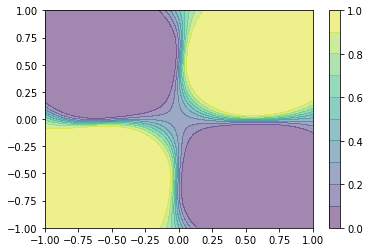

In [358]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(x_size)
    
        for i in range(0, x_size, batchsize):
            
            # ミニバッチ分のデータを取ってくる
            X_batch = x[perm[i:i+batchsize]]
            t_batch = labels[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x_:X_batch, t_:t_batch})
            
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss /x_size
        print('Train loss %.5f  ' %(loss))

        # Test model
        #print ("Test Accuracy: %.3f"%(accuracy.eval(feed_dict={x_: x, t_: labels})))
    
    X_test, Y_test = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)    
    probs = sess.run(y_, feed_dict={x_:x_test, t_:labels})
    Probs = probs.reshape(100, 100)
    levels = np.linspace(0, 1, 11)
    plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
    plt.colorbar()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()